In [41]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Global TF-IDF Vectorizer to avoid redundant instantiation
vectorizer = TfidfVectorizer()

In [42]:
# Sample shapes and edges for graph 1
shapes1 = [
    {'id': 1, 'type': 'terminal', 'center': (0, 0), 'text': 'Start'},
    {'id': 2, 'type': 'process', 'center': (1, 1), 'text': 'Collect Data'},
    {'id': 3, 'type': 'decision', 'center': (2, 2), 'text': 'Data Complete?'},
    {'id': 4, 'type': 'process', 'center': (3, 1), 'text': 'Fill Missing Data'},
    {'id': 5, 'type': 'process', 'center': (4, 0), 'text': 'Analyze Data'},
    {'id': 6, 'type': 'terminal', 'center': (5, -1), 'text': 'End'},
]


edges1 = [
    {'source': 1, 'target': 2},  # Start -> Collect Data
    {'source': 2, 'target': 3},  # Collect Data -> Data Complete?
    {'source': 3, 'target': 4},  # Data Complete? -> Fill Missing Data
    {'source': 4, 'target': 3},  # Fill Missing Data -> Data Complete? (retry)
    {'source': 3, 'target': 5},  # Data Complete? -> Analyze Data
    {'source': 5, 'target': 6},  # Analyze Data -> End
]


# Sample shapes and edges for graph 2
shapes2 = [
    {'id': 1, 'type': 'terminal', 'center': (0, 0), 'text': 'Start'},
    {'id': 2, 'type': 'process', 'center': (1, 1), 'text': 'Collect Customer Data'},  # Minor change here
    {'id': 3, 'type': 'decision', 'center': (2, 2), 'text': 'Data Complete?'},
    {'id': 4, 'type': 'process', 'center': (3, 1), 'text': 'Validate Data'},  # Minor change here
    {'id': 5, 'type': 'process', 'center': (4, 0), 'text': 'Analyze Information'},  # Minor change here
    {'id': 6, 'type': 'terminal', 'center': (5, -1), 'text': 'End'},
]



edges2 = [
    {'source': 1, 'target': 2},  # Start -> Collect Customer Data
    {'source': 2, 'target': 3},  # Collect Customer Data -> Data Complete?
    {'source': 3, 'target': 4},  # Data Complete? -> Validate Data
    {'source': 4, 'target': 3},  # Validate Data -> Data Complete? (retry)
    {'source': 3, 'target': 5},  # Data Complete? -> Analyze Information
    {'source': 5, 'target': 6},  # Analyze Information -> End
]



In [43]:
# Step 1: Graph Construction
def build_graph(shapes, edges):
    """
    Build a directed graph from shapes and edges.

    Args:
        shapes (list): List of dictionaries containing shape attributes.
        edges (list): List of dictionaries containing edge connections.

    Returns:
        nx.DiGraph: A directed graph representing the flowchart.
    """
    G = nx.DiGraph()
    for shape in shapes:
        G.add_node(shape['id'], type=shape['type'], center=shape['center'], text=shape['text'])
    for edge in edges:  # edges based on arrows
        G.add_edge(edge['source'], edge['target'])
    pos1 = nx.spring_layout(G)  # You can use other layout algorithms if needed
    nx.draw(G, pos1, with_labels=True, node_color='lightblue', node_size=1500, font_size=10)
    plt.title("Graph 1")
    plt.show()
    return G

In [44]:
# Step 2: Text Similarity
def text_similarity(text1, text2):
    """
    Compute cosine similarity between two texts using TF-IDF.

    Args:
        text1 (str): First text.
        text2 (str): Second text.

    Returns:
        float: Cosine similarity between the two texts.
    """
    tfidf = vectorizer.fit_transform([text1, text2])
    return cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]

In [45]:
# Step 3: Node Similarity
def node_similarity(node1, node2):
    """
    Compute similarity between two nodes based on their attributes.

    Args:
        node1 (dict): Attributes of the first node.
        node2 (dict): Attributes of the second node.

    Returns:
        float: Similarity score between the two nodes.
    """
    # Compare shape type (exact match)
    type_sim = 1 if node1['type'] == node2['type'] else 0

    # Compare text (cosine similarity using TF-IDF)
    text_sim = text_similarity(node1['text'], node2['text'])

    # Compare spatial position (Euclidean distance between centers)
    center1 = node1['center']
    center2 = node2['center']
    spatial_dist = ((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2) ** 0.5
    spatial_sim = 1 / (1 + spatial_dist)  # Normalize to [0, 1]

    # Weighted combination of similarities
    return 0.4 * type_sim + 0.5 * text_sim + 0.1 * spatial_sim

In [46]:
#Step 4: Edge Similarity
def edge_similarity(graph1, graph2):
    """
    Compute similarity between edges of two graphs.

    Args:
        graph1 (nx.DiGraph): First graph.
        graph2 (nx.DiGraph): Second graph.

    Returns:
        float: Edge similarity score.
    """
    common_edges = len(set(graph1.edges) & set(graph2.edges))
    total_edges = max(len(graph1.edges), len(graph2.edges))
    return common_edges / total_edges if total_edges > 0 else 0

In [59]:
#Step 5: Graph Similarity
def graph_similarity(graph1, graph2):
    """
    Compute structural similarity between two graphs.

    Args:
        graph1 (nx.DiGraph): First graph.
        graph2 (nx.DiGraph): Second graph.

    Returns:
        float: Structural similarity score.
    """
    # Node similarity
    node_sim = 0
    matched_nodes = 0
    for node1 in graph1.nodes:
        for node2 in graph2.nodes:
            sim = node_similarity(graph1.nodes[node1], graph2.nodes[node2])
            if sim > 0.7:  # Threshold for matching nodes
                node_sim += sim
                matched_nodes += 1
    node_sim = node_sim / matched_nodes if matched_nodes > 0 else 0

    # Edge similarity
    edge_sim = edge_similarity(graph1, graph2)

    # Weighted combination of node and edge similarity
    print("Node similarity: ", node_sim)
    print("Edge similarity: ", edge_sim)
    return 0.6 * node_sim + 0.4 * edge_sim

In [60]:
#Step 6: Overall similarity
def overall_similarity(graph1, graph2):
    """
    Compute overall similarity between two graphs, combining structural and textual similarity.

    Args:
        graph1 (nx.DiGraph): First graph.
        graph2 (nx.DiGraph): Second graph.

    Returns:
        float: Overall similarity score.
    """
    # Step 1: Structural similarity (already includes textual similarity in node_similarity)
    structural_sim = graph_similarity(graph1, graph2)

    # Step 2: Combine structural similarity with any additional metrics if needed
    # (In this case, no additional textual similarity is required)
    return structural_sim

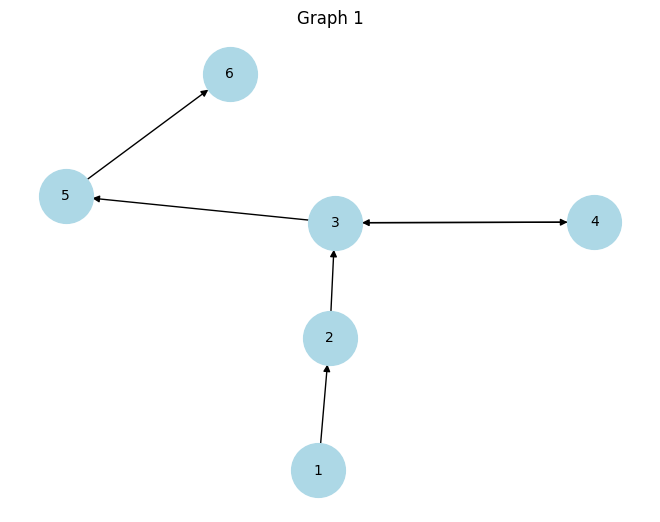

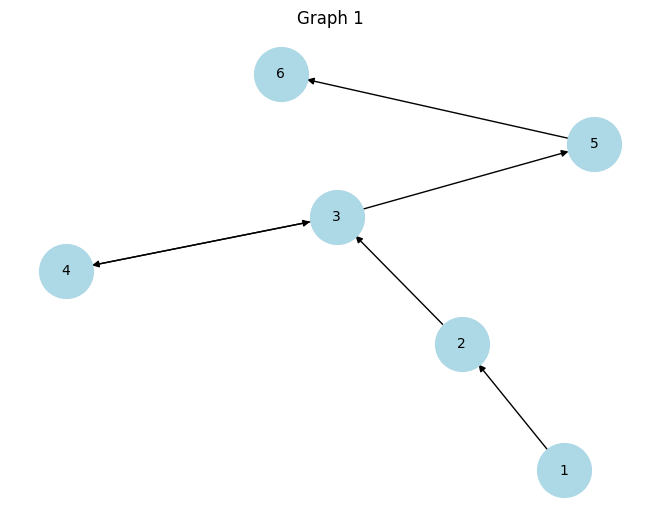

In [61]:
# Main Workflow
graph1 = build_graph(shapes1, edges1)
graph2 = build_graph(shapes2, edges2)

In [62]:
# Calculate similarity score
similarity_score = overall_similarity(graph1, graph2)

Node similarity:  0.9636621583257843
Edge similarity:  1.0
Overall similarity:  0.9781972949954706


In [63]:
print("Similarity Score:", similarity_score)

Similarity Score: 0.9781972949954706


In [64]:
if(similarity_score>0.7):
    print("Graphs are similar")
else:
    print("Graphs are not similar")

Graphs are similar
